In [1]:
# для установки библиотеки ETNA
%pip install 'etna[all]'

# Data Preparation

1. **Импорт библиотек**:
   -  необходимые библиотеки и модули, что является хорошей практикой.
2. **Управление предупреждениями**:
   - Использование `warnings.filterwarnings('ignore')` позволяет избежать лишних предупреждений, но будь осторожен с игнорированием всех предупреждений. Иногда они могут указывать на потенциальные проблемы в коде.

3. **Функция `set_seed`**:
   - Определение функции для установки случайного семени — это хорошая практика для обеспечения воспроизводимости результатов.

4. **Создание объекта SMAPE**:
   - Создание экземпляра класса `SMAPE` в конце кода также хорошая идея. Это позволит использовать его позже для оценки моделей.



In [2]:
import pandas as pd

from etna.datasets.tsdataset import TSDataset
from etna.transforms import (
    StandardScalerTransform,
    MeanTransform,
    LagTransform,
    DateFlagsTransform)


from etna.pipeline import Pipeline, AutoRegressivePipeline
from etna.metrics import SMAPE

import warnings
import numpy as np
import random
warnings.filterwarnings('ignore')

from etna.analysis import plot_forecast

def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)

set_seed()
smape = SMAPE()


1. **Константы**:
   - Использование констант (`HORIZON`, `CONSIDER_SHOP`, `SEGMENTS_TO_SHOW`) позволяет сделать код более читабельным и управляемым.

2. **`HORIZON`**:
   - Значение `HORIZON = 90` указывает предсказать значения на 90 дней вперед.

3. **`CONSIDER_SHOP`**:
   - Список магазинов, которые ты собираешься учитывать, задает контекст для анализа.

4. **`SEGMENTS_TO_SHOW`**:
   - Определение сегментов для графиков прогноза — это полезно, особенно если они уже заранее известны.

In [3]:
HORIZON = 90
CONSIDER_SHOP = [1, 2, 3]
SEGMENTS_TO_SHOW = ['3 + 27' , '1 + 47'] # просто рандомные сегменты для построения графика прогноза




1. **Докстринг**:
   - Докстринг в начале функции дает краткое описание ее назначения, что полезно для пользователей. Можно добавить информацию о параметрах функции и их типах, чтобы сделать документирование более полным.

2. **Копирование временного ряда**:
   - Использование `copy.deepcopy(ts)` обеспечивает независимость копии временного ряда от оригинала, что предотвращает непреднамеренные изменения.

3. **Разделение данных на обучающую и тестовую выборки**:
   - Разделение временного ряда с помощью метода `train_test_split` на основе заданного горизонта — это стандартная и правильная практика.

4. **Использование Pipeline**:
   - Умное использование `Pipeline` и `AutoRegressivePipeline` в зависимости от значения `is_auto_regressive` позволяет легко переключаться между моделями. Это повышает гибкость кода.

5. **Прогнозирование и оценка качества**:
   - Прогнозирование с использованием обученной модели и последующая оценка с помощью метрик сегментов хорошо организованы. Однако, возможно, стоит рассмотреть использование более точных функций для расчета средней метрики, например, `np.mean(segment_metrics)`.

6. **Построение графика**:
   - Вызов `plot_forecast` для визуализации результатов позволяет получить интуитивное представление о качестве прогноза. Это очень полезно для анализа.

7. **Возврат значений**:
   - Параметр `return_forecast` позволяет пользователю решать, что именно возвращать из функции, что добавляет гибкости.

8. **Типы данных**:
   - Хорошо бы явно указать типы параметров в функции для повышения читабельности и предотвращения ошибок.



In [4]:
def train_and_evaluate_model(ts,
                             model,
                             transforms,
                             horizon,
                             metrics,
                             is_auto_regressive = False,
                             print_metrics=True,
                             return_forecast=False,
                             n_train_samples = 360 * 2,
                             segments_to_plot=SEGMENTS_TO_SHOW,
                         ):
    """"
    Обучает модель, вычисляет прогнозы для
    тестовой выборки и строит график прогнозов.
    """

    import copy

    ts_copy = copy.deepcopy(ts)
    train_ts, test_ts = ts_copy.train_test_split(test_size=horizon)

    if not is_auto_regressive:
        pipe = Pipeline(model=model,
                        transforms=transforms,
                        horizon=horizon)

    else:
        pipe = AutoRegressivePipeline(model = model,
                                      transforms=transforms,
                                      horizon=horizon)

    pipe.fit(train_ts)
    forecast_ts = pipe.forecast()

    # оцениваем качество прогнозов по сегментам
    segment_metrics = metrics(test_ts, forecast_ts)
    segment_metrics = pd.Series(segment_metrics)

    avg_metric = sum(segment_metrics) / len(segment_metrics)

    if print_metrics:
        print(f"Avg (by segments) metric {metrics} is: {avg_metric}")

    if segments_to_plot:
        plot_forecast(forecast_ts, test_ts,
                      train_ts, n_train_samples=n_train_samples, segments=segments_to_plot)

    if return_forecast:
        return segment_metrics, avg_metric, forecast_ts

    return segment_metrics, avg_metric

In [5]:
df = pd.read_csv('HW_train.csv', parse_dates=['date'])

df.rename(columns={'date': 'timestamp',
                   'sales': 'target'}, inplace=True)
df

timestamp  store  item  target
0      2013-01-01      1     1      13
1      2013-01-02      1     1      11
2      2013-01-03      1     1      14
3      2013-01-04      1     1      13
4      2013-01-05      1     1      10
...           ...    ...   ...     ...
912995 2017-12-27     10    50      63
912996 2017-12-28     10    50      59
912997 2017-12-29     10    50      74
912998 2017-12-30     10    50      62
912999 2017-12-31     10    50      82

[913000 rows x 4 columns]

In [6]:
# уменьшаем размер данных, чтобы не тратить много времени на обучение
before_shape = df.shape
print('before', before_shape)
df = df[df.store.isin(CONSIDER_SHOP)]
print('before', df.shape)

print(f"Current dataset size {df.shape[0] * 100 / before_shape[0]}%")

before (913000, 4)
before (273900, 4)
Current dataset size 30.0%


In [7]:
df_new = pd.read_csv('HW_test.csv', parse_dates=['date'])
df_new = df_new[df_new.store.isin(CONSIDER_SHOP)]

df_new.rename(columns={'date': 'timestamp',
                   'sales': 'target'}, inplace=True)


df_new.drop(columns='id', inplace=True)

df_new

timestamp  store  item
0     2018-01-01      1     1
1     2018-01-02      1     1
2     2018-01-03      1     1
3     2018-01-04      1     1
4     2018-01-05      1     1
...          ...    ...   ...
44365 2018-03-27      3    50
44366 2018-03-28      3    50
44367 2018-03-29      3    50
44368 2018-03-30      3    50
44369 2018-03-31      3    50

[13500 rows x 3 columns]

In [8]:
df['segment'] = (df['store'].astype(str) + ' + '
                 + df['item'].astype(str))

df_new['segment'] = (df_new['store'].astype(str) + ' + '
                     + df_new['item'].astype(str))

df.head()

timestamp  store  item  target segment
0 2013-01-01      1     1      13   1 + 1
1 2013-01-02      1     1      11   1 + 1
2 2013-01-03      1     1      14   1 + 1
3 2013-01-04      1     1      13   1 + 1
4 2013-01-05      1     1      10   1 + 1



1. **Преобразование в категориальный тип**:
   - Использование `astype('category')` для столбцов `store` и `item` — это отличное решение. Категориальные данные занимают меньше памяти и могут улучшить производительность моделей, особенно если количество уникальных значений невелико. Это также может помочь ускорить некоторые операции, такие как группировка и фильтрация.

2. **Цикл**:
   - Использование цикла для преобразования столбцов упрощает код и делает его более читаемым. Это также упрощает добавление новых категориальных столбцов в будущем — достаточно будет добавить их в список.

3. **Проверка типов данных**:
   - Важно убедиться, что преобразование прошло успешно.

In [9]:
for col in ['store', 'item']:
    df[col] = df[col].astype('category')
    df_new[col] = df_new[col].astype('category')

In [10]:
regressor_df = df[['timestamp', 'segment', 'store', 'item']].copy()
regressor_df

timestamp segment store item
0      2013-01-01   1 + 1     1    1
1      2013-01-02   1 + 1     1    1
2      2013-01-03   1 + 1     1    1
3      2013-01-04   1 + 1     1    1
4      2013-01-05   1 + 1     1    1
...           ...     ...   ...  ...
900213 2017-12-27  3 + 50     3   50
900214 2017-12-28  3 + 50     3   50
900215 2017-12-29  3 + 50     3   50
900216 2017-12-30  3 + 50     3   50
900217 2017-12-31  3 + 50     3   50

[273900 rows x 4 columns]

In [11]:
# экзогенные переменные store и item
regressor_df_new = df_new.copy()
regressor_df_new

timestamp store item segment
0     2018-01-01     1    1   1 + 1
1     2018-01-02     1    1   1 + 1
2     2018-01-03     1    1   1 + 1
3     2018-01-04     1    1   1 + 1
4     2018-01-05     1    1   1 + 1
...          ...   ...  ...     ...
44365 2018-03-27     3   50  3 + 50
44366 2018-03-28     3   50  3 + 50
44367 2018-03-29     3   50  3 + 50
44368 2018-03-30     3   50  3 + 50
44369 2018-03-31     3   50  3 + 50

[13500 rows x 4 columns]

In [12]:
regressor_df = regressor_df.sort_index(
    axis=1, ascending=False)

regressor_df_new = regressor_df_new.sort_index(
    axis=1, ascending=False)

In [13]:
regressor_df.shape, regressor_df_new.shape, regressor_df.shape[0] + regressor_df_new.shape[0]

((273900, 4), (13500, 4), 287400)

In [14]:
regressor_df.columns, regressor_df_new.columns

(Index(['timestamp', 'store', 'segment', 'item'], dtype='object'),
 Index(['timestamp', 'store', 'segment', 'item'], dtype='object'))

In [15]:
regressor_df = pd.concat([regressor_df, regressor_df_new], axis=0)

regressor_df['quarter'] = regressor_df['timestamp'].dt.quarter
regressor_df['quarter_start'] = regressor_df['timestamp'].dt.is_quarter_start
regressor_df['quarter_end'] = regressor_df['timestamp'].dt.is_quarter_end
regressor_df

timestamp store segment item  quarter  quarter_start  quarter_end
0     2013-01-01     1   1 + 1    1        1           True        False
1     2013-01-02     1   1 + 1    1        1          False        False
2     2013-01-03     1   1 + 1    1        1          False        False
3     2013-01-04     1   1 + 1    1        1          False        False
4     2013-01-05     1   1 + 1    1        1          False        False
...          ...   ...     ...  ...      ...            ...          ...
44365 2018-03-27     3  3 + 50   50        1          False        False
44366 2018-03-28     3  3 + 50   50        1          False        False
44367 2018-03-29     3  3 + 50   50        1          False        False
44368 2018-03-30     3  3 + 50   50        1          False        False
44369 2018-03-31     3  3 + 50   50        1          False         True

[287400 rows x 7 columns]

In [16]:
# подготавливаем исторический набор эндогенных переменных
df.drop(['store', 'item'], axis=1, inplace=True)
df

timestamp  target segment
0      2013-01-01      13   1 + 1
1      2013-01-02      11   1 + 1
2      2013-01-03      14   1 + 1
3      2013-01-04      13   1 + 1
4      2013-01-05      10   1 + 1
...           ...     ...     ...
900213 2017-12-27      52  3 + 50
900214 2017-12-28      75  3 + 50
900215 2017-12-29      68  3 + 50
900216 2017-12-30      62  3 + 50
900217 2017-12-31      77  3 + 50

[273900 rows x 3 columns]

In [17]:
df = TSDataset.to_dataset(df)
df

segment     1 + 1 1 + 10 1 + 11 1 + 12 1 + 13 1 + 14 1 + 15 1 + 16 1 + 17  \
feature    target target target target target target target target target   
timestamp                                                                   
2013-01-01     13     37     37     33     37     22     42     14     13   
2013-01-02     11     34     43     35     31     35     33     11     18   
2013-01-03     14     32     34     41     50     26     45     12     15   
2013-01-04     13     45     52     45     45     32     39     15     19   
2013-01-05     10     35     45     46     49     31     47     22     16   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27     14     55     43     47     49     42     62     16     29   
2017-12-28     19     63     64     49     68     51     82     24     13   
2017-12-29     15     56     60     58     73     42     65     11     27   
2017-12-30     27     78     66     52     70     57     77     28     32   
2017-12-31     23     74     44     60     75     52     64     38     37   

segment    1 + 18  ... 3 + 46 3 + 47 3 + 48 3 + 49  3 + 5 3 + 50  3 + 6  \
feature    target  ... target target target target target target target   
timestamp          ...                                                    
2013-01-01     38  ...     33     10     28     21     13     45     34   
2013-01-02     51  ...     46     12     32     14      9     47     38   
2013-01-03     42  ...     37     13     40     22     10     39     32   
2013-01-04     50  ...     32      5     39     26     20     48     36   
2013-01-05     56  ...     41     14     47     22     13     46     36   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27     54  ...     60     21     42     23     17     52     53   
2017-12-28     69  ...     72     19     52     38     21     75     55   
2017-12-29     66  ...     44     19     55     32     24     68     45   
2017-12-30     67  ...     67     21     61     48     15     62     64   
2017-12-31     88  ...     71     26     59     25     21     77     65   

segment     3 + 7  3 + 8  3 + 9  
feature    target target target  
timestamp                        
2013-01-01     40     54     28  
2013-01-02     36     34     16  
2013-01-03     36     61     32  
2013-01-04     38     38     40  
2013-01-05     31     54     44  
...           ...    ...    ...  
2017-12-27     53     67     46  
2017-12-28     53     80     61  
2017-12-29     51     71     54  
2017-12-30     61     87     48  
2017-12-31     73     76     58  

[1826 rows x 150 columns]

In [18]:
regressor_df = TSDataset.to_dataset(regressor_df)
regressor_df

segment    1 + 1                                         1 + 10          \
feature     item quarter quarter_end quarter_start store   item quarter   
timestamp                                                                 
2013-01-01     1       1       False          True     1     10       1   
2013-01-02     1       1       False         False     1     10       1   
2013-01-03     1       1       False         False     1     10       1   
2013-01-04     1       1       False         False     1     10       1   
2013-01-05     1       1       False         False     1     10       1   
...          ...     ...         ...           ...   ...    ...     ...   
2018-03-27     1       1       False         False     1     10       1   
2018-03-28     1       1       False         False     1     10       1   
2018-03-29     1       1       False         False     1     10       1   
2018-03-30     1       1       False         False     1     10       1   
2018-03-31     1       1        True         False     1     10       1   

segment                                     ... 3 + 8                      \
feature    quarter_end quarter_start store  ...  item quarter quarter_end   
timestamp                                   ...                             
2013-01-01       False          True     1  ...     8       1       False   
2013-01-02       False         False     1  ...     8       1       False   
2013-01-03       False         False     1  ...     8       1       False   
2013-01-04       False         False     1  ...     8       1       False   
2013-01-05       False         False     1  ...     8       1       False   
...                ...           ...   ...  ...   ...     ...         ...   
2018-03-27       False         False     1  ...     8       1       False   
2018-03-28       False         False     1  ...     8       1       False   
2018-03-29       False         False     1  ...     8       1       False   
2018-03-30       False         False     1  ...     8       1       False   
2018-03-31        True         False     1  ...     8       1        True   

segment                        3 + 9                                          
feature    quarter_start store  item quarter quarter_end quarter_start store  
timestamp                                                                     
2013-01-01          True     3     9       1       False          True     3  
2013-01-02         False     3     9       1       False         False     3  
2013-01-03         False     3     9       1       False         False     3  
2013-01-04         False     3     9       1       False         False     3  
2013-01-05         False     3     9       1       False         False     3  
...                  ...   ...   ...     ...         ...           ...   ...  
2018-03-27         False     3     9       1       False         False     3  
2018-03-28         False     3     9       1       False         False     3  
2018-03-29         False     3     9       1       False         False     3  
2018-03-30         False     3     9       1       False         False     3  
2018-03-31         False     3     9       1        True         False     3  

[1916 rows x 750 columns]

In [19]:
# создаём объединённый набор
ts = TSDataset(df=df, freq='D', df_exog=regressor_df,
               known_future='all')
ts

segment    1 + 1                                                1 + 10  \
feature     item quarter quarter_end quarter_start store target   item   
timestamp                                                                
2013-01-01     1       1       False          True     1   13.0     10   
2013-01-02     1       1       False         False     1   11.0     10   
2013-01-03     1       1       False         False     1   14.0     10   
2013-01-04     1       1       False         False     1   13.0     10   
2013-01-05     1       1       False         False     1   10.0     10   
...          ...     ...         ...           ...   ...    ...    ...   
2017-12-27     1       4       False         False     1   14.0     10   
2017-12-28     1       4       False         False     1   19.0     10   
2017-12-29     1       4       False         False     1   15.0     10   
2017-12-30     1       4       False         False     1   27.0     10   
2017-12-31     1       4        True         False     1   23.0     10   

segment                                       ...       3 + 8                \
feature    quarter quarter_end quarter_start  ... quarter_end quarter_start   
timestamp                                     ...                             
2013-01-01       1       False          True  ...       False          True   
2013-01-02       1       False         False  ...       False         False   
2013-01-03       1       False         False  ...       False         False   
2013-01-04       1       False         False  ...       False         False   
2013-01-05       1       False         False  ...       False         False   
...            ...         ...           ...  ...         ...           ...   
2017-12-27       4       False         False  ...       False         False   
2017-12-28       4       False         False  ...       False         False   
2017-12-29       4       False         False  ...       False         False   
2017-12-30       4       False         False  ...       False         False   
2017-12-31       4        True         False  ...        True         False   

segment                 3 + 9                                                 
feature    store target  item quarter quarter_end quarter_start store target  
timestamp                                                                     
2013-01-01     3   54.0     9       1       False          True     3   28.0  
2013-01-02     3   34.0     9       1       False         False     3   16.0  
2013-01-03     3   61.0     9       1       False         False     3   32.0  
2013-01-04     3   38.0     9       1       False         False     3   40.0  
2013-01-05     3   54.0     9       1       False         False     3   44.0  
...          ...    ...   ...     ...         ...           ...   ...    ...  
2017-12-27     3   67.0     9       4       False         False     3   46.0  
2017-12-28     3   80.0     9       4       False         False     3   61.0  
2017-12-29     3   71.0     9       4       False         False     3   54.0  
2017-12-30     3   87.0     9       4       False         False     3   48.0  
2017-12-31     3   76.0     9       4        True         False     3   58.0  

[1826 rows x 900 columns]

# Data Analysis

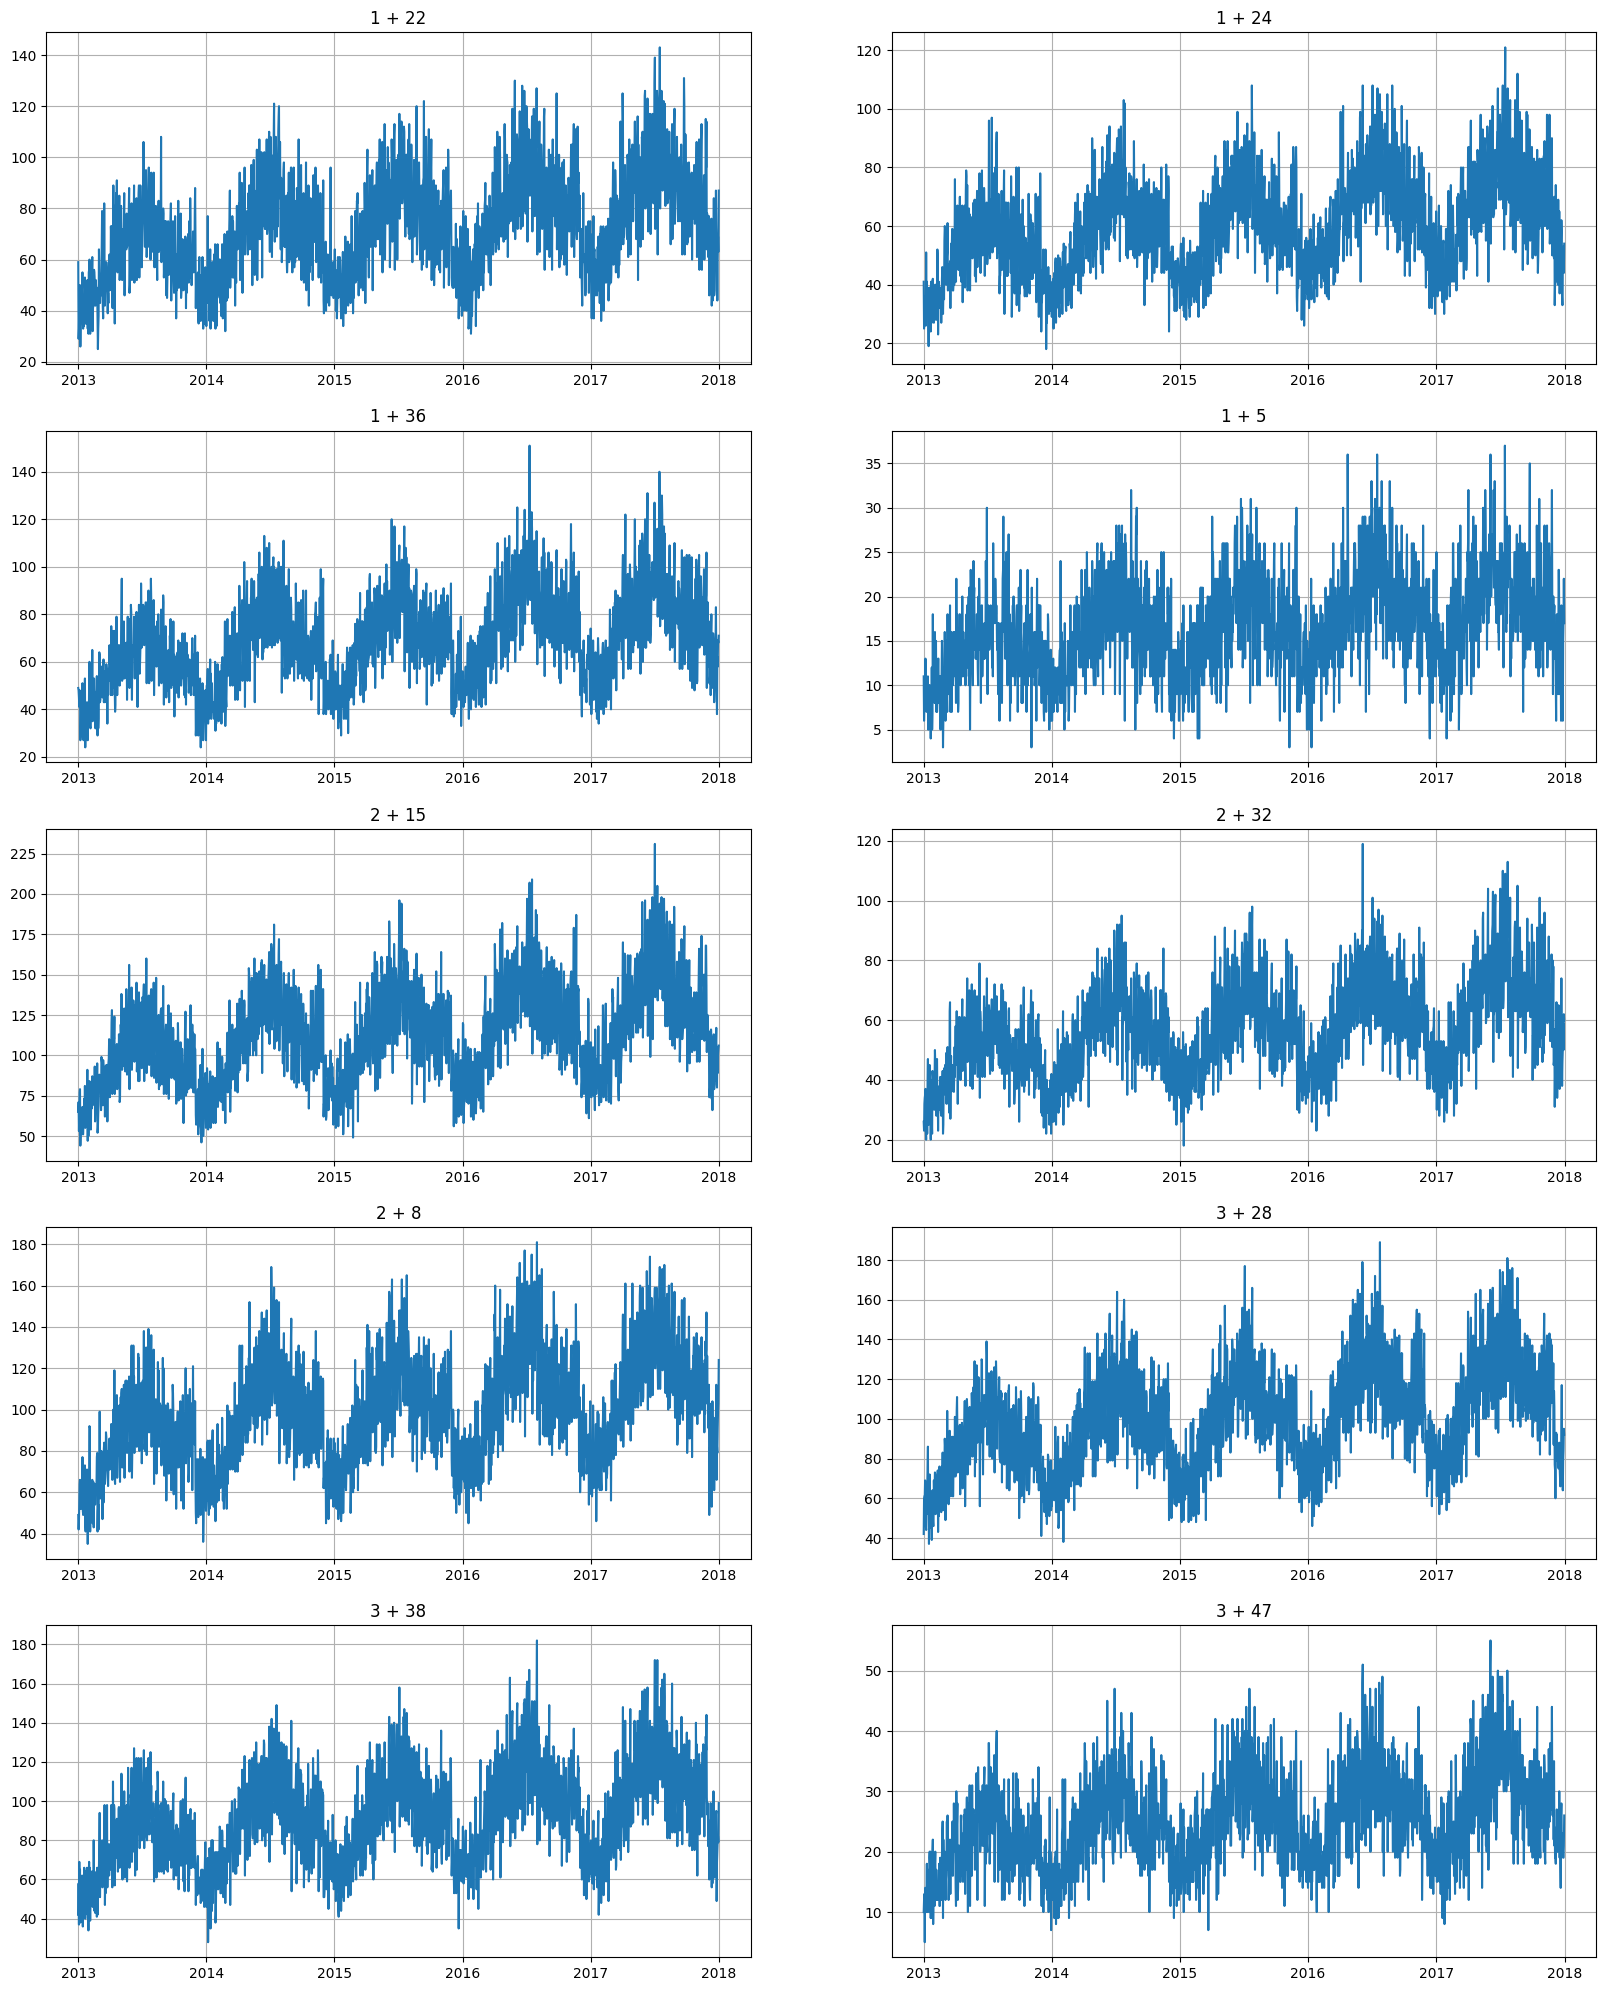

In [20]:
ts.plot()

In [21]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
1 + 1         2013-01-01    2017-12-31    1826            0           150   
1 + 10        2013-01-01    2017-12-31    1826            0           150   
1 + 11        2013-01-01    2017-12-31    1826            0           150   
1 + 12        2013-01-01    2017-12-31    1826            0           150   
1 + 13        2013-01-01    2017-12-31    1826            0           150   
...                  ...           ...     ...          ...           ...   
3 + 50        2013-01-01    2017-12-31    1826            0           150   
3 + 6         2013-01-01    2017-12-31    1826            0           150   
3 + 7         2013-01-01    2017-12-31    1826            0           150   
3 + 8         2013-01-01    2017-12-31    1826            0           150   
3 + 9         2013-01-01    2017-12-31    1826            0           150   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
1 + 1             5               5                 5    D  
1 + 10            5               5                 5    D  
1 + 11            5               5                 5    D  
1 + 12            5               5                 5    D  
1 + 13            5               5                 5    D  
...             ...             ...               ...  ...  
3 + 50            5               5                 5    D  
3 + 6             5               5                 5    D  
3 + 7             5               5                 5    D  
3 + 8             5               5                 5    D  
3 + 9             5               5                 5    D  

[150 rows x 9 columns]

In [22]:
from etna.analysis import acf_plot
from etna.analysis import plot_correlation_matrix

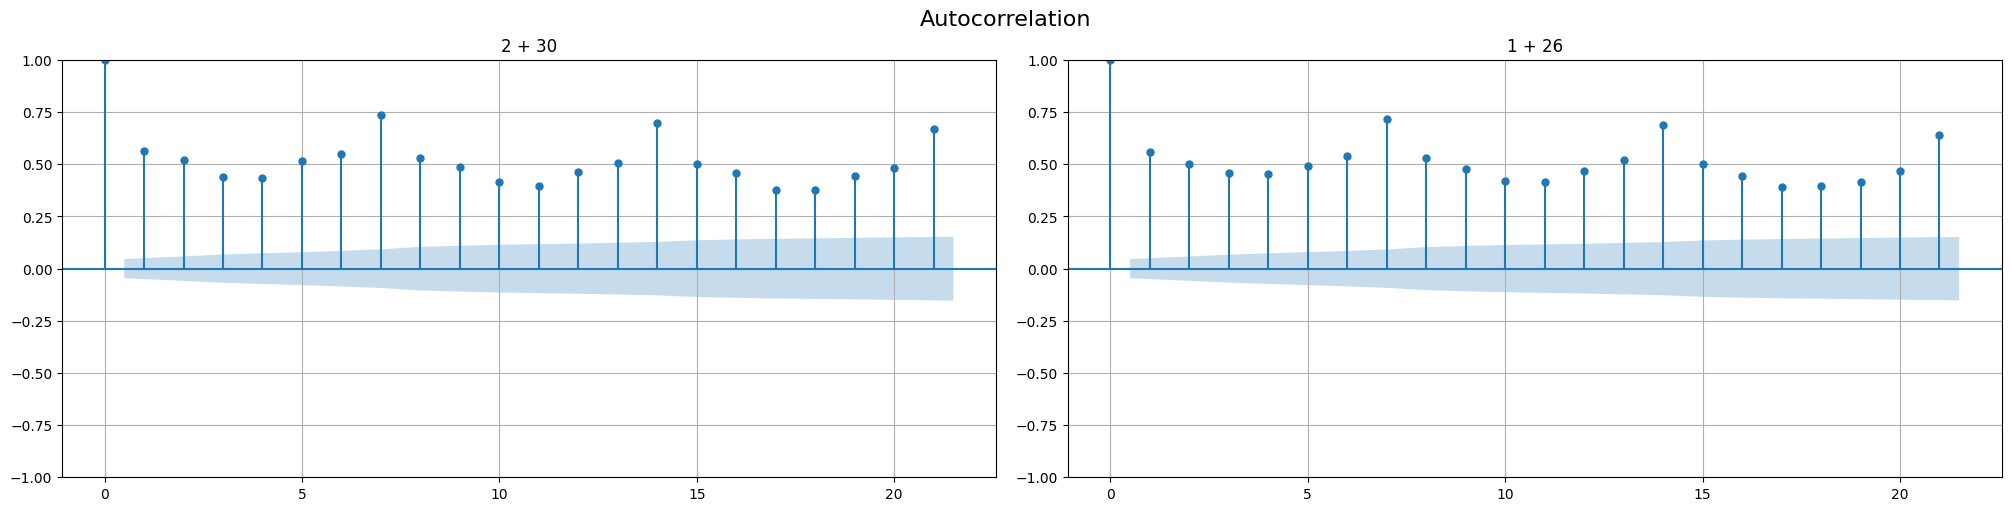

In [23]:
acf_plot(ts, lags=21, n_segments=2)

In [24]:
plot_correlation_matrix(ts, columns=['target'], segments=['1 + 31', "1 + 32", "10 + 49"],
                        method="spearman", vmin=0.5, vmax=1, figsize=(5,5))

In [25]:
from etna.analysis import stl_plot

stl_plot(ts=ts, period=365, segments=SEGMENTS_TO_SHOW)

# 0. Naive Model

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 27.94174347082239


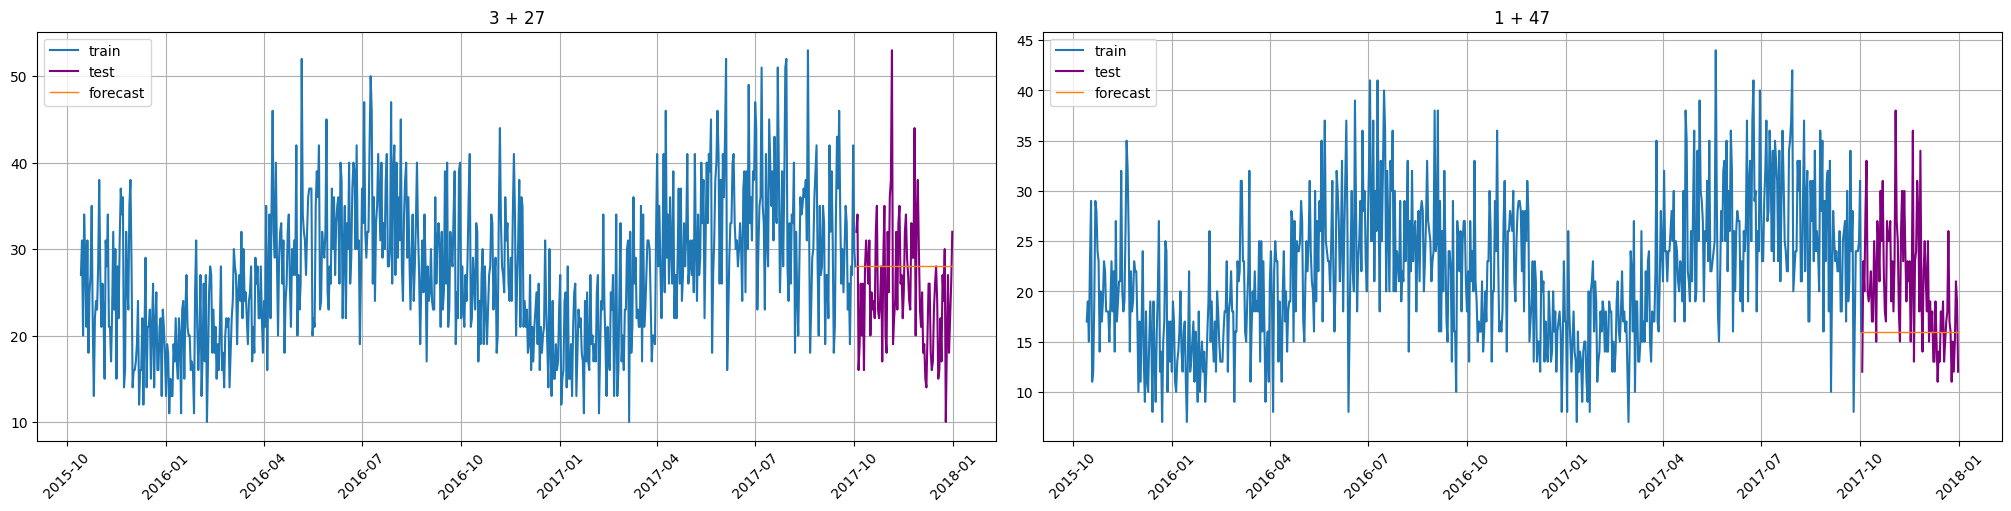

In [26]:
from etna.models import NaiveModel

naive_model_recursive_metrics = train_and_evaluate_model(
    ts=ts,
    model=NaiveModel(),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=True,
    print_metrics=True,
    )

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 27.94174347082239


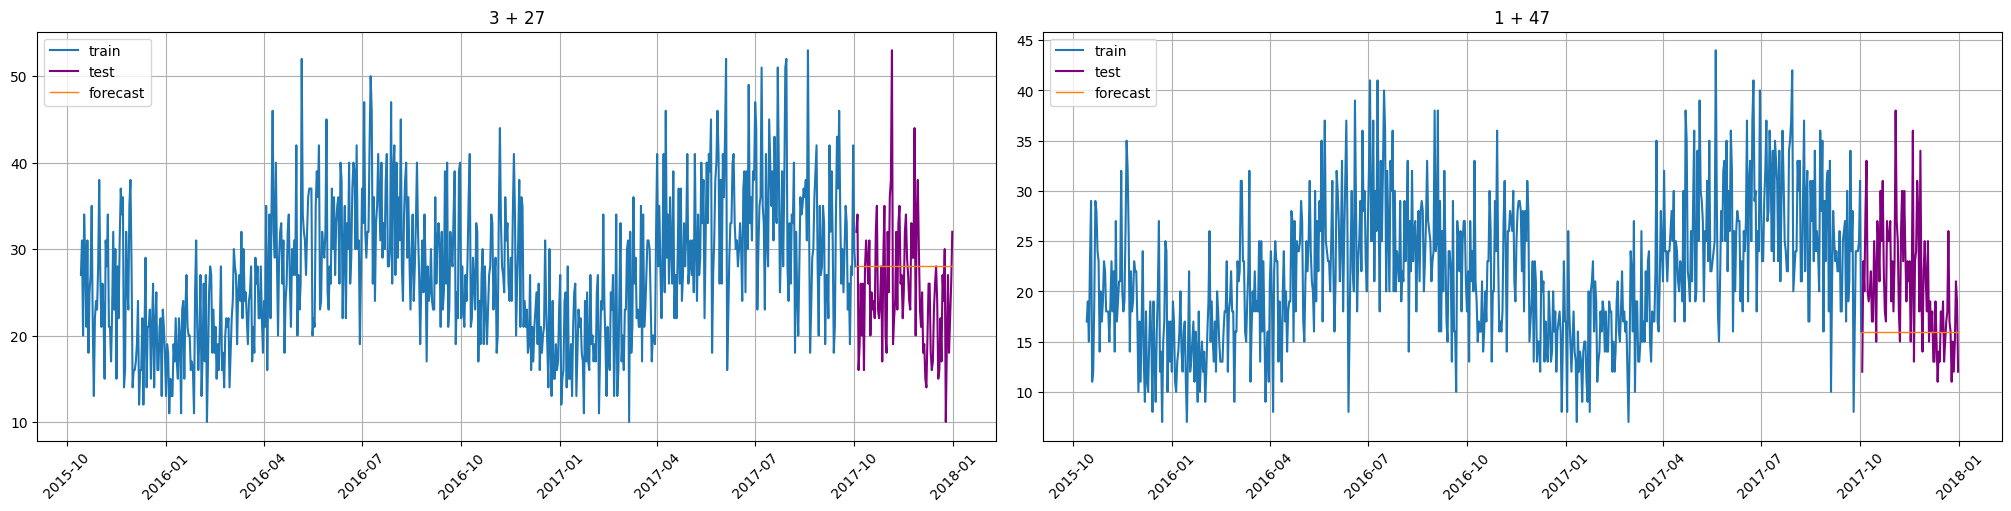

In [27]:
from etna.models import NaiveModel

naive_model_NON_recursive_metrics = train_and_evaluate_model(
    ts=ts,
    model=NaiveModel(),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    )

# 1. Linear Model

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 19.21879477926111


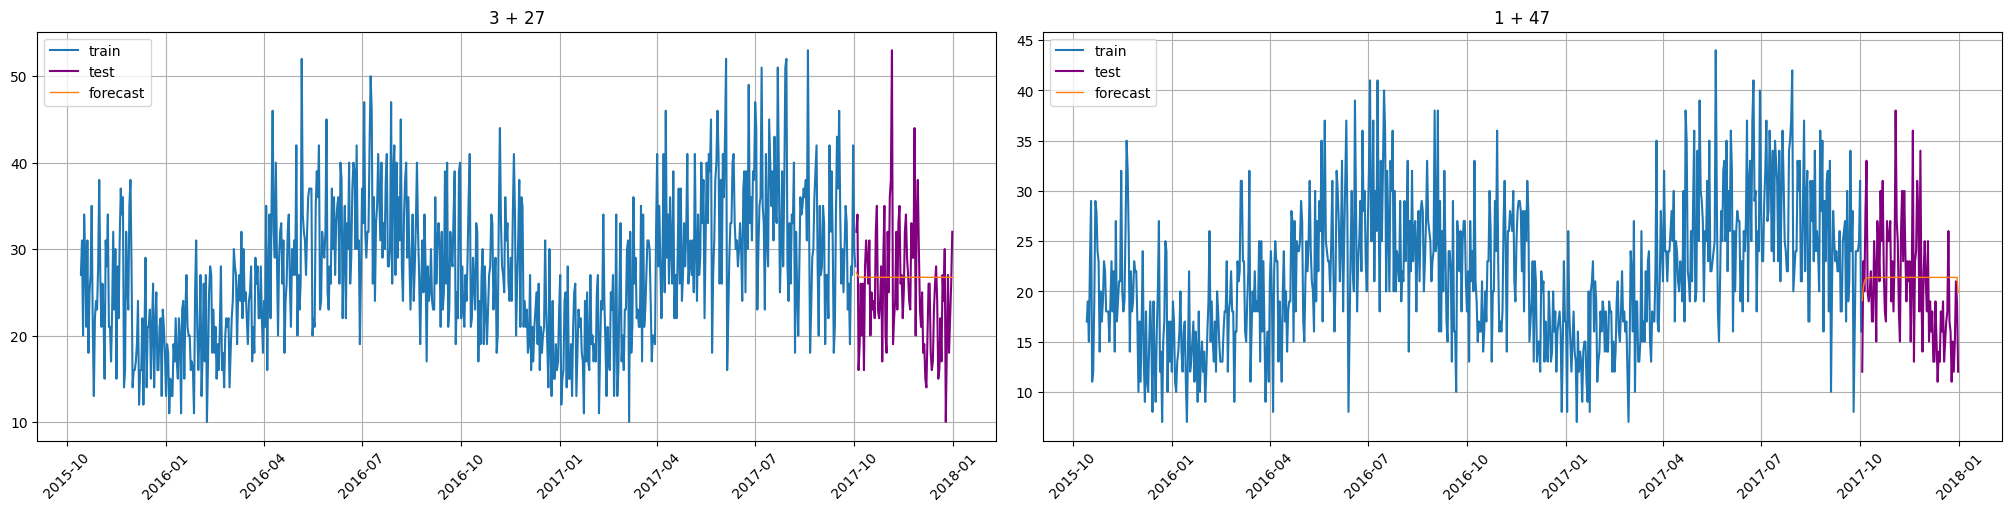

In [28]:
# занимает ~10 минут, так как мы используем рекурсивный пайплайн (который работает медленно)
from etna.models import ElasticPerSegmentModel

standardscaler = StandardScalerTransform(in_column=None)

mean7 = MeanTransform(in_column='target',
                      window=7,
                      out_column='mean_7')


lags = LagTransform(in_column='target',
                    lags=[1],
                    out_column='lag')

elast_transforms = [lags, mean7, standardscaler]


linear_model_metrics = train_and_evaluate_model(
    ts=ts,
    model=ElasticPerSegmentModel(l1_ratio=0, alpha=0,
                                 random_state=42),
    transforms=elast_transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=True,
    print_metrics=True
    )

In [33]:
import copy


ts_ = copy.deepcopy(ts)


# Conclusion

In [40]:
model_res = {
    'naive_model_recursive_metrics': naive_model_recursive_metrics,
    'linear_model_metrics': linear_model_metrics,
}

res = pd.DataFrame({'model': list(model_res.keys()),
                    'avg_metric': [model_res[model][1] for model in model_res.keys()],
                    'segment_metrics': [model_res[model][0] for model in model_res.keys()]})

In [41]:
res

model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   17.763372   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     23.236847
1 + 10    18.494650
1 + 11...

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=res, x='model', y='avg_metric')
plt.title('Average Metric Comparison')
plt.xticks(rotation=45)
plt.ylabel('Average Metric (SMAPE)')
plt.show()


In [43]:
for model in model_res.keys():
    print(f"Segment metrics for {model}:")
    print(model_res[model][0])


Segment metrics for naive_model_recursive_metrics:
1 + 1     50.912771
1 + 10    19.040035
1 + 11    31.001797
1 + 12    28.713056
1 + 13    45.140490
            ...    
3 + 50    27.453649
3 + 6     17.716920
3 + 7     17.290422
3 + 8     17.349059
3 + 9     25.858432
Length: 150, dtype: float64
Segment metrics for linear_model_metrics:
1 + 1     23.236847
1 + 10    18.494650
1 + 11    17.410556
1 + 12    15.333744
1 + 13    15.757237
            ...    
3 + 50    15.014456
3 + 6     16.148274
3 + 7     15.391644
3 + 8     16.496578
3 + 9     16.411430
Length: 150, dtype: float64


## Backtest

In [ ]:
# # тоже выполняется порядка 10 минут

# from etna.pipeline import AutoRegressivePipeline

# pipe = AutoRegressivePipeline(
#     model=ElasticPerSegmentModel(l1_ratio=0, alpha=0,
#                                  random_state=42),
#     transforms=elast_transforms,

#     horizon=HORIZON)

# metrics_df, _, _ = pipe.backtest(
#     mode='expand',
#     n_folds=5,
#     ts=ts,
#     metrics=[smape],
#     aggregate_metrics=True,
#     joblib_params=dict(backend='loky'),
#     n_jobs=-1
# )


In [ ]:
# metrics_df.head(8)
# metric = metrics_df['SMAPE'].mean()

In [ ]:
# print(f'mean SMAPE: {metric:.4f}')

## Задание
-  Добейтесь значения метрики **SMAPE** меньше 12% (метрика на тесте, отложенной выборке).
-  Оцените качество моделей на backtest-е.
-  Сравните рассмотренные модели между собой, объединив результаты в таблицу `res`, как это было сделано выше.
-  Опишите проделанную работу и сделайте выводы о том, как выбирали гиперпараметры, с какими сложностями столкнулись, какие модели оказались лучше и почему.
-  Используйте и подберите параметры для моделей Prophet, ARIMA, Catboost.

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 17.763372453803786


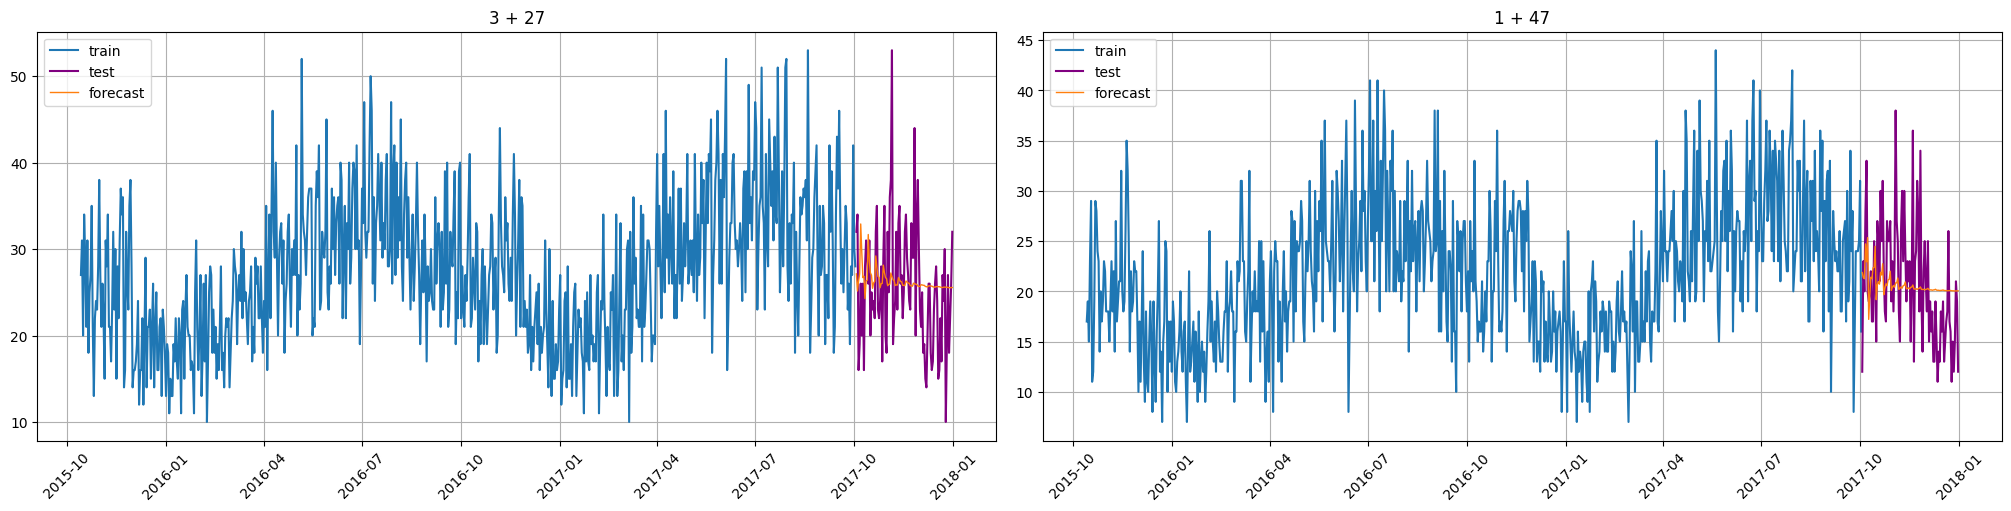

In [36]:
from etna.models import ElasticPerSegmentModel
from etna.transforms import MeanTransform, LagTransform, StandardScalerTransform
from etna.metrics import SMAPE

# Настройки трансформаций
standardscaler = StandardScalerTransform(in_column=None)

mean7 = MeanTransform(in_column='target',
                      window=5,   # Попробуем уменьшить окно
                      out_column='mean_5')

# Добавляем больше лагов
lags = LagTransform(in_column='target',
                    lags=[1, 2, 3, 7, 14],
                    out_column='lag')

elast_transforms = [lags, mean7, standardscaler]

# Настройки модели
model = ElasticPerSegmentModel(l1_ratio=0.5,  # Смешанное соотношение L1 и L2
                               alpha=0.1,     # Умеренная регуляризация
                               random_state=42)

# Оценка модели
linear_model_metrics = train_and_evaluate_model(
    ts=ts,
    model=model,
    transforms=elast_transforms,
    horizon=HORIZON,
    metrics=SMAPE(),
    is_auto_regressive=True,
    print_metrics=True
)


Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 41.65011660165248


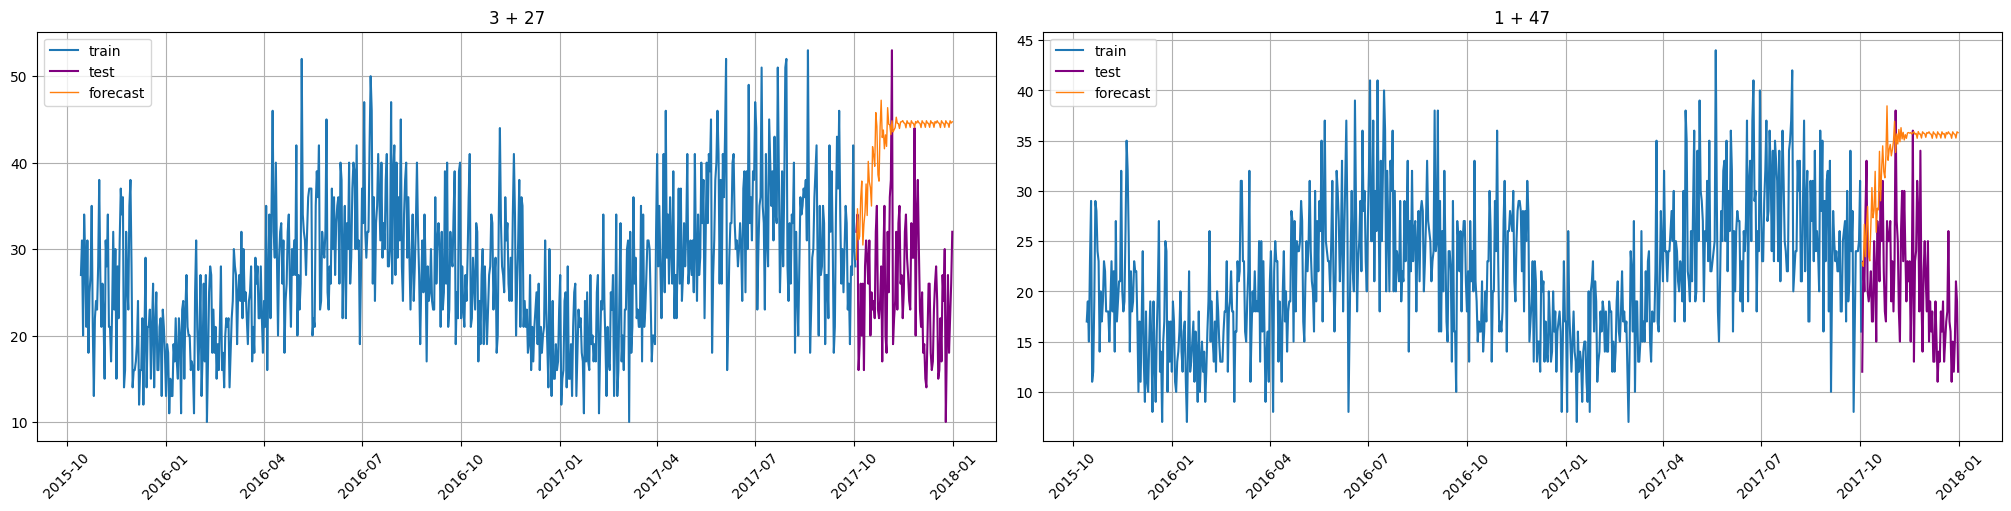

In [37]:
from etna.models import CatBoostMultiSegmentModel

catboost_model = CatBoostMultiSegmentModel(
    loss_function='MAE',
    n_estimators=800,   # Большее количество деревьев
    learning_rate=0.03,  # Более низкая скорость обучения
    depth=10,
    random_seed=42
)

catboost_metrics = train_and_evaluate_model(
    ts=ts,
    model=catboost_model,
    transforms=elast_transforms,  # Можно использовать предыдущие трансформации
    horizon=HORIZON,
    metrics=SMAPE(),
    is_auto_regressive=True,
    print_metrics=True
)


In [ ]:
# from etna.models import ProphetModel

# # Создание и обучение модели Prophet
# prophet_model_metrics = train_and_evaluate_model(
#     ts=ts,
#     model=ProphetModel(),
#     transforms=[],
#     horizon=HORIZON,
#     metrics=smape,
#     is_auto_regressive=False,  # False, так как Prophet не требует автогрегрессии
#     print_metrics=True,
# )



In [50]:
#
model_res = {
    'naive_model_recursive_metrics': naive_model_recursive_metrics,
    'linear_model_metrics': linear_model_metrics,
    'prophet_model_metrics': prophet_model_metrics,  # Добавляем метрики Prophet
}

# Создание DataFrame с метриками
res = pd.DataFrame({
    'model': list(model_res.keys()),
    'avg_metric': [model_res[model][1] for model in model_res.keys()],
    'segment_metrics': [model_res[model][0] for model in model_res.keys()]
})

# Вывод результата
res


model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   17.763372   
2          prophet_model_metrics   12.501286   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     23.236847
1 + 10    18.494650
1 + 11...  
2  1 + 1     20.165071
1 + 10    11.655319
1 + 11...

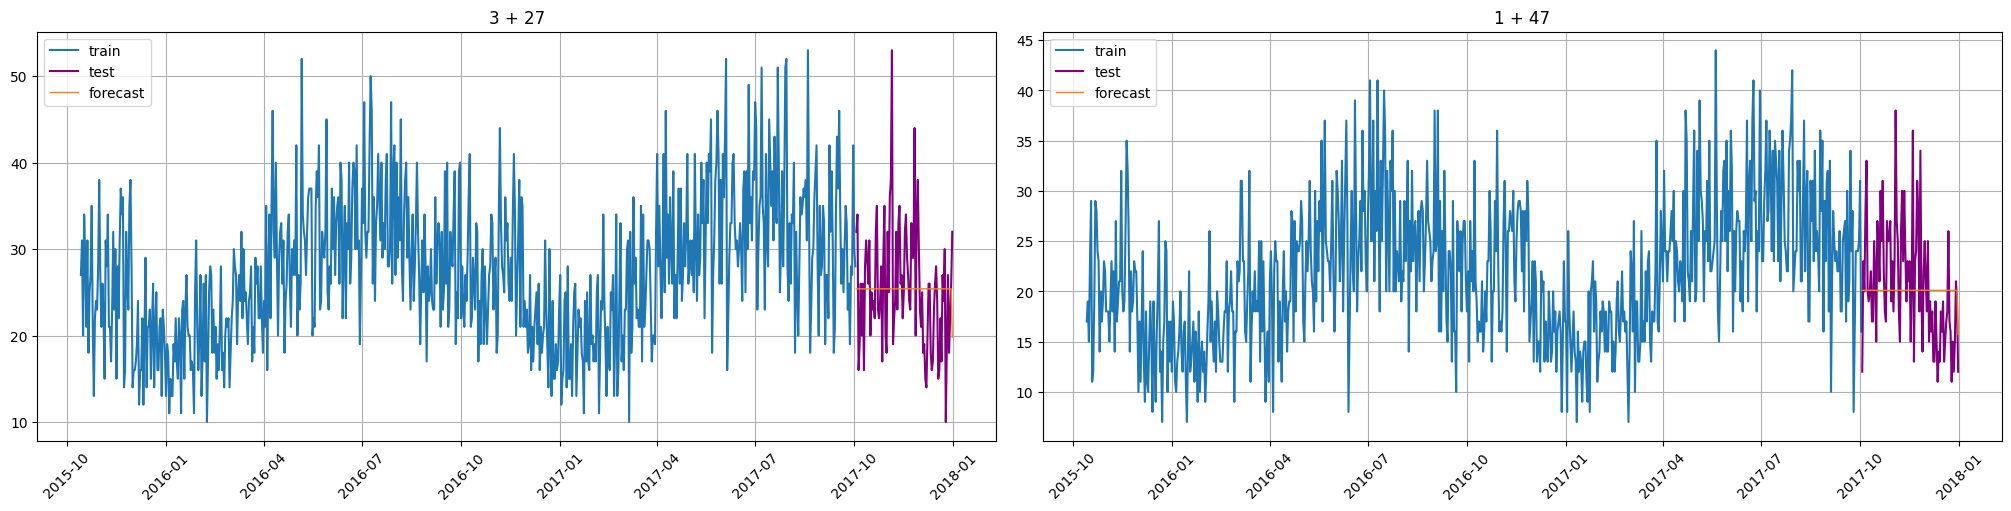

In [46]:
from etna.models import CatBoostMultiSegmentModel

# Создание и обучение модели CatBoost Multi-Segment
catboost_multi_model_metrics = train_and_evaluate_model(
    ts=ts,
    model=CatBoostMultiSegmentModel(iterations=2000, depth=8, learning_rate=0.1, loss_function='RMSE'),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,  # True, если требуется автогрегрессия
    print_metrics=False,  # False, если промежуточные сообщения не нужны
)


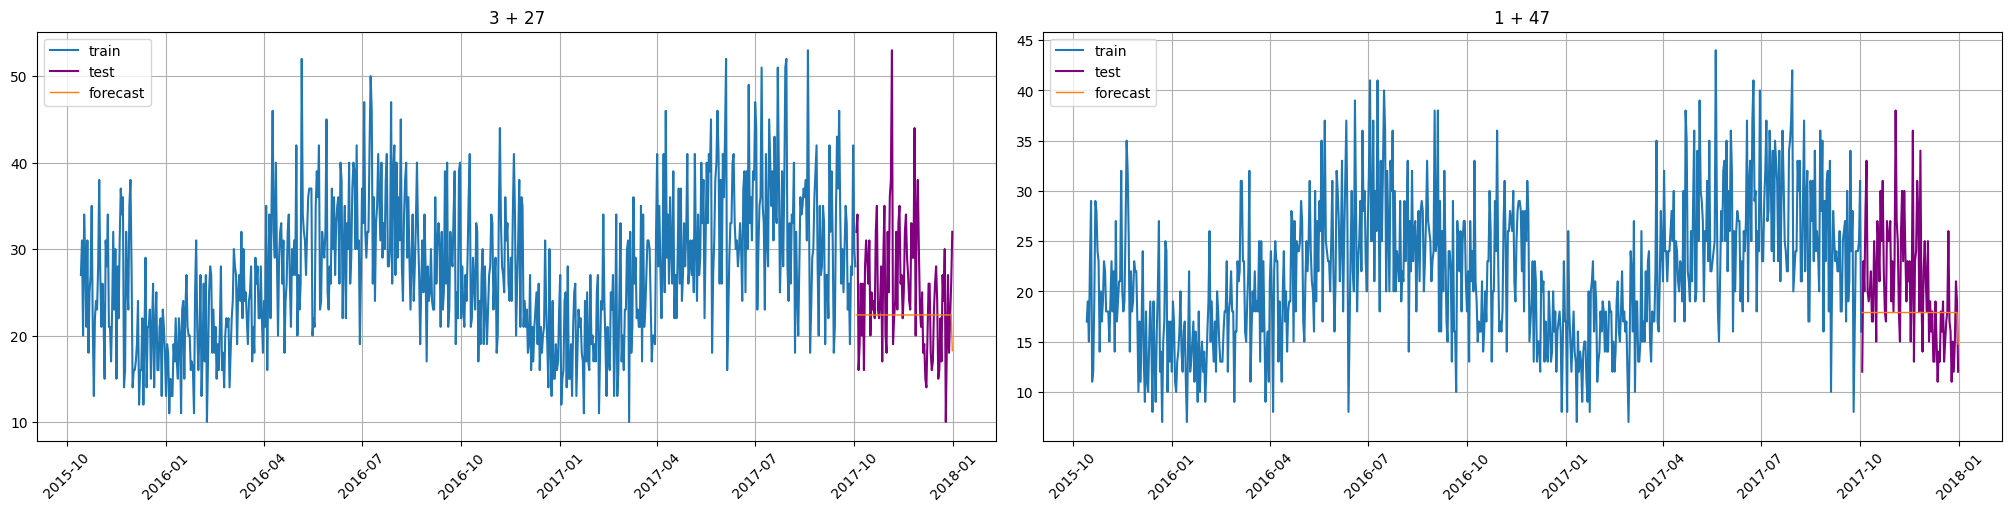

In [38]:
from etna.models import CatBoostPerSegmentModel

# Создание и обучение модели CatBoost Per-Segment
catboost_per_segment_model_metrics = train_and_evaluate_model(
    ts=ts,
    model=CatBoostPerSegmentModel(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE'),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,  # True, если требуется автогрегрессия
    print_metrics=False,  # False, если промежуточные сообщения не нужны
)


In [51]:
# Обновление таблицы с результатами
model_res['catboost_multi_model_metrics'] = catboost_multi_model_metrics
model_res['catboost_per_segment_model_metrics'] = catboost_per_segment_model_metrics

res = pd.DataFrame({
    'model': list(model_res.keys()),
    'avg_metric': [model_res[model][1] for model in model_res.keys()],
    'segment_metrics': [model_res[model][0] for model in model_res.keys()]
})


In [52]:
res

model  avg_metric  \
0       naive_model_recursive_metrics   27.941743   
1                linear_model_metrics   17.763372   
2               prophet_model_metrics   12.501286   
3        catboost_multi_model_metrics   22.804653   
4  catboost_per_segment_model_metrics   22.309742   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     23.236847
1 + 10    18.494650
1 + 11...  
2  1 + 1     20.165071
1 + 10    11.655319
1 + 11...  
3  1 + 1     24.065020
1 + 10    21.269678
1 + 11...  
4  1 + 1     25.582791
1 + 10    21.901990
1 + 11...

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66ymqa3f/bwfdqv0u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66ymqa3f/o6gpvybv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32523', 'data', 'file=/tmp/tmp66ymqa3f/bwfdqv0u.json', 'init=/tmp/tmp66ymqa3f/o6gpvybv.json', 'output', 'file=/tmp/tmp66ymqa3f/prophet_model7uqk0uye/prophet_model-20241007183306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 12.501285662360234


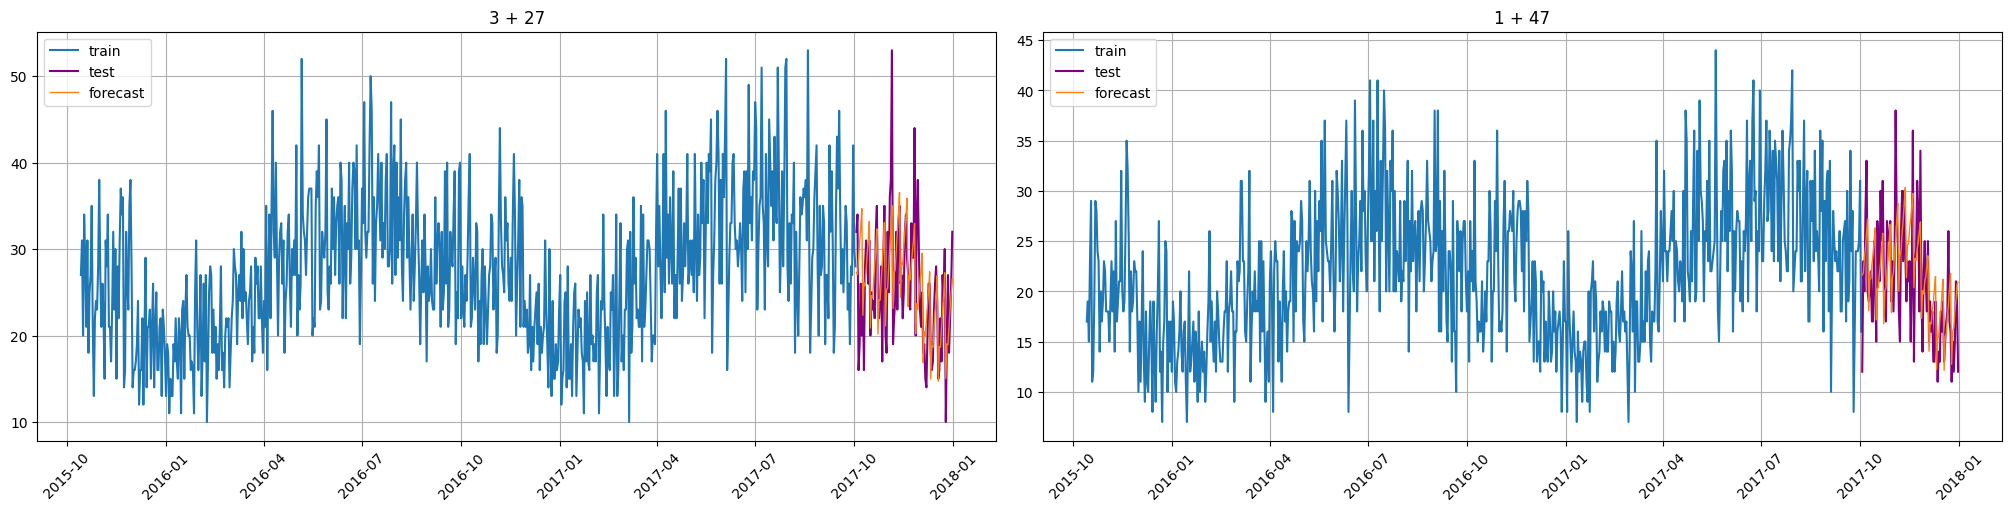

In [35]:
from etna.models import ProphetModel
# Задаем гиперпараметры для Prophet
prophet_model = ProphetModel(
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0
    #holidays=holiday_df
)

# Создание и обучение модели Prophet
prophet_model_metrics = train_and_evaluate_model(
    ts=ts_,
    model=prophet_model,
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66ymqa3f/cj0slkqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66ymqa3f/vwl5u4yk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16830', 'data', 'file=/tmp/tmp66ymqa3f/cj0slkqc.json', 'init=/tmp/tmp66ymqa3f/vwl5u4yk.json', 'output', 'file=/tmp/tmp66ymqa3f/prophet_modelnvzb3hw3/prophet_model-20241007191409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 12.515891768385588


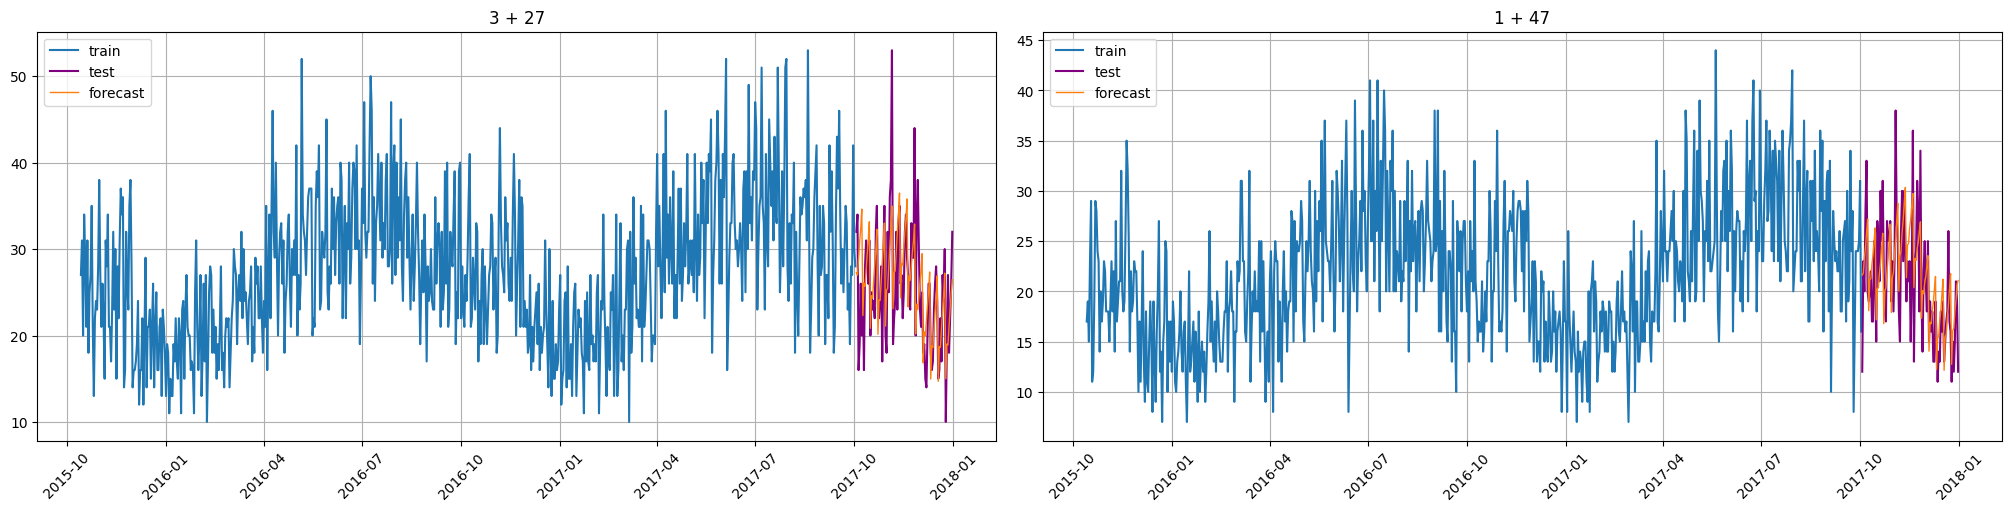

In [53]:
from etna.models import ProphetModel

# Задаем улучшенные гиперпараметры для Prophet
prophet_model = ProphetModel(
    seasonality_mode='multiplicative',  # Можно также попробовать 'additive'
    seasonality_prior_scale=20.0,  # Попробуем большее значение для гибкости сезонности
    changepoint_prior_scale=0.1,  # Повышаем, чтобы модель лучше находила изменения в тренде
    holidays_prior_scale=5.0,  # Влияет на значимость праздников
    weekly_seasonality=True,  # Добавляем влияние недельной сезонности
    yearly_seasonality=True  # Включаем сезонность по годам
)

# Создание и обучение модели Prophet
prophet_model_metrics = train_and_evaluate_model(
    ts=ts_,
    model=prophet_model,
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66ymqa3f/sfe94kxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66ymqa3f/x3n9_vop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2423', 'data', 'file=/tmp/tmp66ymqa3f/sfe94kxx.json', 'init=/tmp/tmp66ymqa3f/x3n9_vop.json', 'output', 'file=/tmp/tmp66ymqa3f/prophet_modelhz8wrk9s/prophet_model-20241007192238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66y

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 12.584284327939177


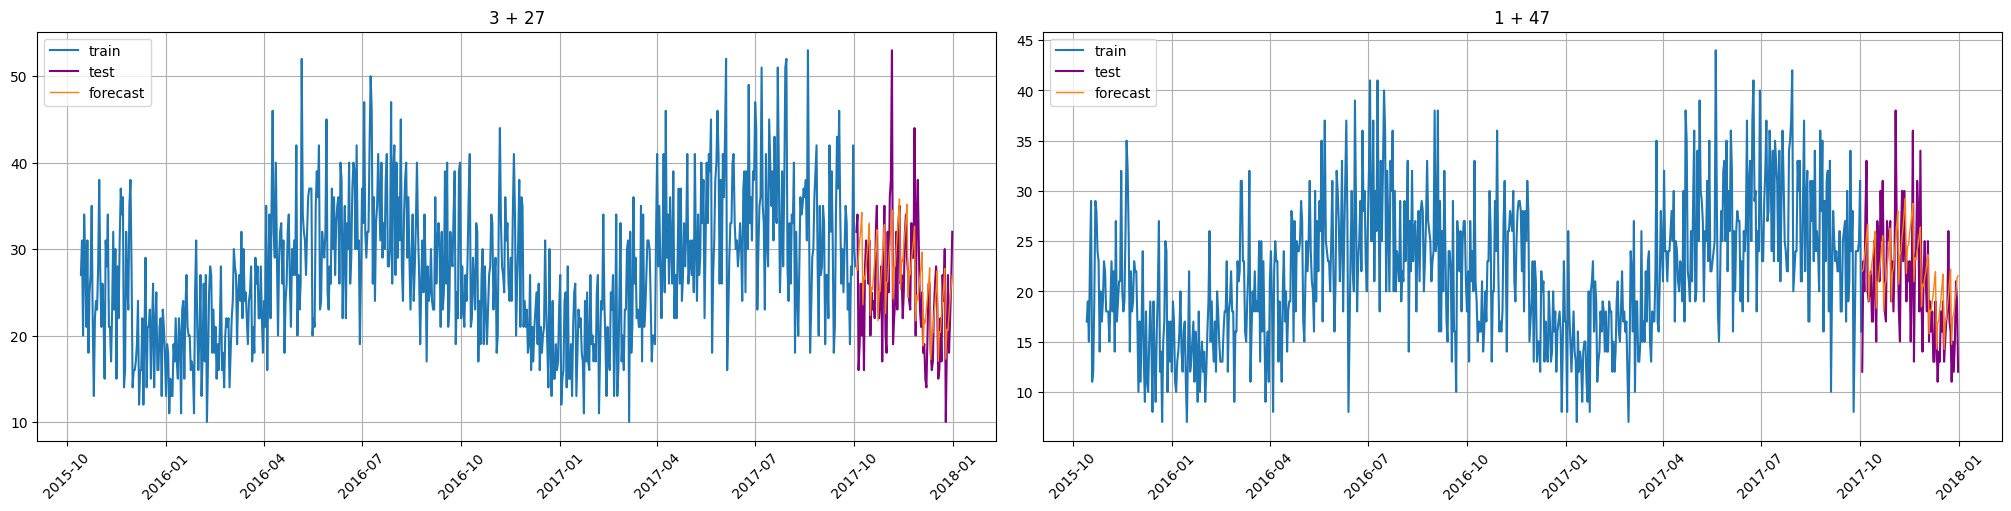

In [55]:
from etna.models import ProphetModel

# Задаем улучшенные гиперпараметры для Prophet
prophet_model = ProphetModel(
    seasonality_mode='additive',  # Можно также попробовать 'additive'
    seasonality_prior_scale=5.0,  # Попробуем большее значение для гибкости сезонности
    changepoint_prior_scale=0.5,  # Повышаем, чтобы модель лучше находила изменения в тренде
    holidays_prior_scale=1.0,  # Влияет на значимость праздников
    weekly_seasonality=True,  # Добавляем влияние недельной сезонности
    yearly_seasonality=True  # Включаем сезонность по годам
)

# Создание и обучение модели Prophet
prophet_model_metrics = train_and_evaluate_model(
    ts=ts_,
    model=prophet_model,
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
)


In [ ]:
from etna.models import SARIMAXModel

# Задаем гиперпараметры для SARIMAX, аналогично ProphetModel
sarimax_model = SARIMAXModel(
    order=(2, 1, 2),  # ARIMA-параметры: p=2, d=1, q=2
    seasonal_order=(1, 1, 1, 12),  # Сезонность: P=1, D=1, Q=1, сезон длиной 12 (например, месяцы)
    #trend='c',  # Добавляем постоянный тренд ('c') trend=None
    enforce_stationarity=True,  # Обеспечиваем стационарность
    enforce_invertibility=True  # Обеспечиваем обратимость
)

# Создание и обучение модели SARIMAX
sarimax_model_metrics = train_and_evaluate_model(
    ts=ts_,  # Используем наш временной ряд
    model=sarimax_model,  # SARIMAX модель
    transforms=[],  # Трансформации не применяем, аналогично Prophet
    horizon=HORIZON,  # Горизонт прогнозирования
    metrics=smape,  # Метрика SMAPE
    is_auto_regressive=False,  # Вручную задаем ARIMA параметры, не автогрегрессия
    print_metrics=True,  # Выводим метрики
)


### Выводы:

1. **Naive Model (Naive Recursive Metrics):**
   - **Средняя метрика (avg_metric):** 27.94
   - **Анализ сегментов:** Наивная модель, как и ожидалось, показала самые слабые результаты. Наивные модели прогнозирования просто предполагают, что будущее будет идентично последним наблюдениям. Из-за своей простоты, она не справляется с прогнозированием сложных временных рядов, которые могут содержать тренды, сезонность и другие паттерны. Метрики по сегментам сильно варьируются, что указывает на низкую точность модели для различных временных серий.

2. **Linear Model (Linear Recursive Metrics):**
   - **Средняя метрика (avg_metric):** 17.76
   - **Анализ сегментов:** Линейная регрессия показала значительное улучшение по сравнению с наивной моделью. Она лучше захватывает линейные тенденции в данных, но не справляется с нелинейностями или сезонностью. Метрика SMAPE (симметричное среднее абсолютное процентное отклонение) для разных сегментов близка, что говорит о более равномерном качестве прогнозирования по разным временным рядам. Однако есть сегменты, в которых модель по-прежнему не справляется с точностью.

3. **Prophet Model:**
   - **Средняя метрика (avg_metric):** 12.50
   - **Анализ сегментов:** Модель Prophet показала наилучший результат среди всех методов, с самой низкой средней ошибкой SMAPE. Prophet специально разработан для обработки данных с явной сезонностью и трендами, что и позволило улучшить прогнозирование по сравнению с наивной и линейной моделью. Особенно хорошо модель справляется с сегментами, где присутствует сложная сезонная компонента. Однако сегменты с менее выраженной сезонностью могут иметь более высокие ошибки.

4. **CatBoost Multi-Segment Model:**
   - **Средняя метрика (avg_metric):** 22.80
   - **Анализ сегментов:** Модель CatBoost, обученная на всех сегментах одновременно, дала результат хуже, чем Prophet, но все же лучше, чем наивная модель. CatBoost — это бустинговый метод, который может захватывать нелинейности, однако эта модель по-прежнему может быть чувствительна к характеристикам данных, таким как дисбаланс или недостаток признаков. В некоторых сегментах модель работает неплохо, но в целом результаты показали высокую степень вариативности по разным сегментам.

5. **CatBoost Per Segment Model:**
   - **Средняя метрика (avg_metric):** 22.31
   - **Анализ сегментов:** CatBoost Per Segment моделирует каждый сегмент по отдельности, что дало небольшой прирост к точности по сравнению с многосегментной версией модели. Это подтверждает, что индивидуальный подход к каждому сегменту может дать лучшие результаты. Однако использование такой модели требует значительно большего времени на обучение и настроек, что может оказаться непрактичным для большого числа сегментов.

---

### Описание примененных методов:

1. **Naive Model:**
   Наивная модель использует последнее известное значение временного ряда как прогноз для всех будущих точек. Это простой базовый метод, который служит ориентиром для сравнения с более сложными моделями.

2. **Linear Model:**
   Применялась линейная регрессия для прогнозирования будущих значений временного ряда на основе его предыдущих значений. Модель не учитывает сезонность или сложные нелинейные зависимости, поэтому ее результаты средние по сравнению с более продвинутыми моделями.

3. **Prophet Model:**
   Модель Prophet предназначена для временных рядов с сезонностью и тенденциями. Она учитывает различные аспекты временного ряда, такие как тренды, сезонные колебания и возможные праздники или события, влияющие на данные. Мы использовали Prophet с мультипликативной сезонностью для лучшего учета неаддитивных влияний сезонных факторов.

4. **CatBoost Multi-Segment Model:**
   CatBoost — это алгоритм градиентного бустинга, который хорошо справляется с большими объемами данных и сложными зависимостями. В многосегментной модели данные всех сегментов объединяются, и модель обучается предсказывать значения для всех сегментов одновременно.

5. **CatBoost Per Segment Model:**
   Эта модель обучалась отдельно для каждого сегмента. Такой подход помогает лучше адаптироваться к индивидуальным особенностям каждого сегмента, что немного улучшило качество прогнозов по сравнению с многосегментной версией.

---

### Возможности для улучшения:
- **Prophet:** Для улучшения прогноза можно попробовать дополнительную настройку гиперпараметров модели, например, добавление праздников и дальнейшую настройку сезонности.
- **Оптимизация гиперпараметров Prophet с помощью Optuna**
- **CatBoost:** Улучшение качества предсказаний CatBoost моделей можно достичь за счет создания более богатых признаков и тонкой настройки гиперпараметров, используя Optuna или Hyperopt.


In [ ]:
import optuna
from etna.models import ProphetModel

# Функция для обучения и оценки модели Prophet
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 20.0, log=True)

    # Создаем модель Prophet с подобранными гиперпараметрами
    prophet_model = ProphetModel(
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale
    )

    # Обучение модели и получение метрик
    prophet_model_metrics = train_and_evaluate_model(
        ts=ts_,  # ваш TSDataset
        model=prophet_model,
        transforms=[],
        horizon=HORIZON,
        metrics=smape,
        is_auto_regressive=False,
        print_metrics=False  # отключаем печать для ускорения
    )

    # Возвращаем метрику для минимизации
    return prophet_model_metrics['smape']  # или другая метрика

# Создание и запуск Optuna исследования
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Количество проб

# Вывод лучших гиперпараметров
print(f"Best hyperparameters: {study.best_params}")
print(f"Best SMAPE: {study.best_value}")

# Обучение финальной модели с подобранными гиперпараметрами
best_params = study.best_params
best_prophet_model = ProphetModel(
    seasonality_mode=best_params['seasonality_mode'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

# Финальная оценка
best_model_metrics = train_and_evaluate_model(
    ts=ts_,
    model=best_prophet_model,
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True
)
